# NLP Intent Classification Model (Yellow Messenger Assignment)

**Problem Statement** : Build a classification model using these utterances as the training set for classifying the intents for new utterances. 

Dataset contains 1450 items . In this dataset all the 1450 utterances are labelled with intents. 

In [0]:
# Importing the Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Importing the dataset
dt = pd.read_csv("/content/drive/My Drive/bmw_training_set.csv",encoding="utf-8")
#dt = pd.read_csv("bmw_training_set.csv",encoding="utf-8")

In [48]:
# Exploring the dataset
dt.head()

,Intent,Utterance
0,who_brand_ambd,who is brandambd
1,future_cars,future cars
2,ismart,smart cars
3,bmw_fuel,tell me about fuel type
4,who_brand_ambd,who is your brand ambassador


In [49]:
dt.describe()

,Intent,Utterance
count,1451,1451
unique,144,1414
top,inconvenience,hello bmw
freq,107,3


In [50]:
intent = dt["Intent"]
utterance = list(dt["Utterance"])
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 2 columns):
Intent       1451 non-null object
Utterance    1451 non-null object
dtypes: object(2)
memory usage: 22.8+ KB


In [51]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Tokenization

In [0]:
# Converting the sentences to words and lemmatizing the words
lemmatizer = WordNetLemmatizer()
def cleaning(utterance):
    words = []
    
    for s in utterance:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        words.append([lemmatizer.lemmatize(i.lower()) for i in w])
    return words  

In [53]:
print(utterance[:20])

['who is brandambd', 'future cars', 'smart cars', 'tell me about fuel type', 'who is your brand ambassador', 'how much is it for bmw car', 'is bmw available in delhi', 'why not an indian actor as brandambd', 'when is brandambd  coming to India', 'Can I book bmw in advance?', 'brand ambassador', 'apply for dealership', 'who represents your brand', 'will it run on petrol or diesel', 'Is bmw powered by Internet', 'why british actor', 'Is bmw available in surat', 'brandambd visit india', 'bmw garages car club', 'are there any prebooking available for bmw']


In [54]:
cleaned_words = cleaning(utterance)
print(len(cleaned_words))
print(cleaned_words[:10])  

1451
[['who', 'is', 'brandambd'], ['future', 'car'], ['smart', 'car'], ['tell', 'me', 'about', 'fuel', 'type'], ['who', 'is', 'your', 'brand', 'ambassador'], ['how', 'much', 'is', 'it', 'for', 'bmw', 'car'], ['is', 'bmw', 'available', 'in', 'delhi'], ['why', 'not', 'an', 'indian', 'actor', 'a', 'brandambd'], ['when', 'is', 'brandambd', 'coming', 'to', 'india'], ['can', 'i', 'book', 'bmw', 'in', 'advance']]


In [0]:
# Creating tokenizer
def create_tokenizer(words,filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

# Getting maximum length
def max_length(words):
    return(len(max(words, key = len)))



In [56]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 925 and Maximum length = 29


### Encoding

#### Input Encoding

In [0]:
# Encoding list of words
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [58]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
encoded_doc[:10]

[[76, 3, 247],
 [218, 4],
 [132, 4],
 [21, 13, 17, 219, 89],
 [76, 3, 22, 71, 172],
 [15, 66, 3, 33, 16, 1, 4],
 [3, 1, 39, 9, 576],
 [38, 40, 64, 292, 429, 18, 247],
 [25, 3, 247, 346, 6, 42],
 [20, 5, 30, 1, 9, 347]]

In [0]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [60]:
padded_doc = padding_doc(encoded_doc, max_length)
padded_doc[:10]

array([[ 76,   3, 247,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [218,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [132,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 21,  13,  17, 219,  89,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 76,   3,  22,  71, 172,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 15,  66,   3,  33,  16,   1,   4,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    

In [61]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (1451, 29)


#### Output Encoding

In [0]:
# Obtnaing the unique token intents
unique_intent = list(set(intent))

In [0]:
#tokenizer with filter changed (removing underscore{_} and dashs{-})
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,/:;<=>?@[\]^`{|}~')

In [64]:
print(output_tokenizer.word_index)

{'who-is-pretty': 1, 'iit_-5-_startups': 2, 'british-chinese': 3, 'program_faredout': 4, 'bmw_price': 5, 'hungry': 6, 'test_drive': 7, 'flip-a-coin': 8, 'total_outlay_earmarked': 9, 'nextcarlaunch': 10, 'solutions_patented': 11, 'ismart': 12, 'download': 13, 'models-for-next-2-years': 14, 'what_is_your_name': 15, 'protection-plans': 16, 'in-how-many-cities-will-it-be-sold-in': 17, 'how-do-i-look': 18, 'bmw_chinese_brand': 19, 'competition-from-kia-seltos': 20, 'mentoring': 21, 'who_brand_ambd': 22, 'boring_tired': 23, 'battery-replace-cost': 24, 'doing': 25, 'compare-variants': 26, 'bmwfeature': 27, 'favorites': 28, 'say-something-funny': 29, 'single-charge': 30, 'bmw_buy': 31, 'angry': 32, 'where-are-you': 33, 'about': 34, 'bmwinternet': 35, 'brand_ambd_to_india': 36, 'likeness': 37, 'are-there-any-issues-in-the-bmw': 38, 'inconvenience': 39, 'fine': 40, 'chinesebrand': 41, 'waiting-period': 42, 'assured-buyback': 43, 'i-miss-you': 44, 'produced-or-assembled': 45, 'i-feel-sad': 46, 'o

In [0]:
encoded_output = output_tokenizer.texts_to_sequences(intent)

In [66]:
print(encoded_output[:10])

[[22], [51], [12], [122], [22], [5], [128], [110], [36], [62]]


In [0]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [68]:
encoded_output.shape

(1451, 1)

In [0]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [0]:
output_one_hot = one_hot(encoded_output)

In [71]:
output_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
output_one_hot.shape

(1451, 144)

### Creating Train and Validation set

In [0]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [74]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1160, 29) and train_Y = (1160, 144)
Shape of val_X = (291, 29) and val_Y = (291, 144)


## Defining Model

In [0]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 256, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(256)))
  model.add(Dense(164,activation = "relu"))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(Dense(144, activation = "softmax"))
  return model
  

### Summary of the model 

In [77]:
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 256)           236800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense_3 (Dense)              (None, 164)               84132     
_________________________________________________________________
dropout_2 (Dropout)          (None, 164)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 164)               656       
_________________________________________________________________
dense_4 (Dense)              (None, 144)               23760     
Total params: 1,395,972
Trainable params: 1,158,844
Non-trainable params: 237,128
______________________________________

#### As i have trained this model on the Colab using GPU. So you can skip this step and move forward by loading the model.h3 file

In [79]:
filename = 'model.h3'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data=(val_X, val_Y), callbacks = [checkpoint])

Train on 1160 samples, validate on 291 samples
Epoch 1/100
1160/1160 [==============================] - 4s 4ms/step - loss: 4.1746 - acc: 0.1483 - val_loss: 4.1666 - val_acc: 0.1340

Epoch 00001: val_loss improved from inf to 4.16660, saving model to model.h3
Epoch 2/100
1160/1160 [==============================] - 4s 4ms/step - loss: 3.9057 - acc: 0.1733 - val_loss: 3.9437 - val_acc: 0.1581

Epoch 00002: val_loss improved from 4.16660 to 3.94373, saving model to model.h3
Epoch 3/100
1160/1160 [==============================] - 4s 4ms/step - loss: 3.6645 - acc: 0.2172 - val_loss: 3.6847 - val_acc: 0.2165

Epoch 00003: val_loss improved from 3.94373 to 3.68466, saving model to model.h3
Epoch 4/100
1160/1160 [==============================] - 4s 4ms/step - loss: 3.3958 - acc: 0.2724 - val_loss: 3.4502 - val_acc: 0.3402

Epoch 00004: val_loss improved from 3.68466 to 3.45017, saving model to model.h3
Epoch 5/100
1160/1160 [==============================] - 4s 4ms/step - loss: 3.0785 - acc

#### Plot for **Training and validation loss**

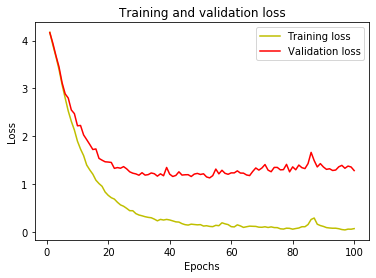

In [80]:

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot for **Training and validation accuracy**

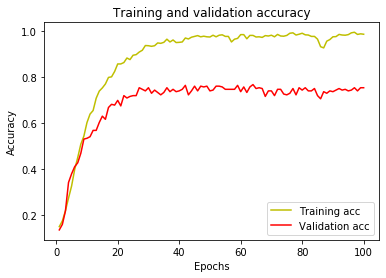

In [81]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaulating the model

In [82]:
cvscores = []
scores = model.evaluate(val_X, val_Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 75.26%
75.26% (+/- 0.00%)


 ### Loading the trained model 

In [84]:
model = load_model("model.h3")

In [0]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [lemmatizer.lemmatize(w.lower()) for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
  pred = model.predict_proba(x)
  return pred

In [0]:
def get_single_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    for i in range(pred.shape[0]):   
        print("%s --- has confidence = %s" % (classes[i], (predictions[i])))

In [0]:
def get_multiple_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    for i in range(pred.shape[1]):   
        print("%s --- has confidence = %s" % (classes[i], (predictions[i])))

In [88]:
text = "Where is bmw garages dealership in bangalore?"
pred = predictions(text)

['where', 'is', 'bmw', 'garage', 'dealership', 'in', 'bangalore']


In [91]:
get_single_output(pred, unique_intent)
#get_multiple_output(pred, unique_intent)

bmw_city --- has confidence = 0.99881727
